In [ ]:
# NEW IRON (12566.768) NEW H (12818.07)
#Adapted from a fitting routine by Natalie Allen

In [1]:
#importing modules
import scipy.optimize as optimize
from scipy.interpolate import griddata
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import operator
import glob
import os
import sys
%matplotlib inline

In [2]:
# implementing natural sorting (ref: https://stackoverflow.com/questions/5967500/how-to-correctly-sort-a-string-with-a-number-inside)

import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [3]:
def fileread(path): #read in the path to the shock files directory, form "S5_Shocks/NewMid/ShockFiles/ShockSpectrum*.csv"
    directory = glob.glob(path)
    directory.sort(key=natural_keys) #key=os.path.getmtime
    files = []
    length = ['1','2','3','4','5','6','7','8']
    for i in directory:
        data = pd.read_csv(i, names = length, engine = 'python')
        files.append(data)
    
    return files


In [4]:
def initial(file):  # taking the important information out of the file (wavelengths and fluxes)
    rawdata = file[-len(file)+88:]
    
    hbvalpoint = file[76:77]
    hbval = float(hbvalpoint.iloc[0]["4"])  #the H flux normalization?
    rawwl = rawdata["1"]  #wavelengths
    
    #converting wavelengths...note this is a python list!
    #old way
#     wl = []
#     for j in rawwl:
#         num = float(j)
#         u = num/10000.  # converting to microns
#         wl.append(u)
    wl = np.array([float(j)/1e4 for j in rawwl])
    
    #reading all normalized fluxes...again, python list
    raweps = rawdata["3"]
    
    #old way
#     eps = []
#     for k in raweps:
#         nums = float(k)
#         eps.append(nums)
    eps = np.array([float(k) for k in raweps])

    #an array of wavelengths and unnormalized flux values
    #old way, just needed to convert to np arrays to allow for array operations
#     uses = []
#     for a in range(len(eps)):
#         vals = [eps[a]*hbval,wl[a]]
#         uses.append(vals)
    uses = [[x, y] for x, y in zip(eps*hbval, wl)]

        
    return uses

In [5]:
def pointlistmake(filelist):  # making a point of (velocity,density) that maps to each wavelength intensity...output is a list
    pointlist = []
    
    for file in filelist:
        #if fslice is from line 10ish, it could be the "run name", which between and underscore and km/s has the velocity, etc
        fslice = file.values[5][0]  #???From below, it looks like it's a list of values at some index within a given file
        
        #looks like the part below grabs the indices in the file between where the velocity might show up?
        unlist = []
        for i in (i for i,x in enumerate(fslice) if x == '_'): # finding the file points containing the velocity
            unlist.append(i)
        fvel = unlist[0] + 1

        for i in (i for i,x in enumerate(fslice) if x == 'k'): # ...?
            lvel = i
        vel = fslice[fvel:lvel] #so this grabs a portion of the values from the slice of file containing the vel and dens? 

        fden = unlist[1] + 1
        for i in (i for i,x in enumerate(fslice) if x == 'g'):  # same for density
            lden = i
        den = fslice[fden:lden]

        point = [vel, den]
        pointlist.append(point)
    
    return(pointlist)

In [6]:
#grabbing a list of unnormalized line fluxes given some line wavelengths and a model file to look in
#output is a list of lists b/c it's a list containing a list of fluxes per file
def modlistmake(file, lams):
    modlist = []
    
    t = 0
    while t < len(file):
        lst = file[t]  #reading in file
        listup = initial(lst)  #initialize means grabbing the lambdas and unnormalizing the fluxes
        
        muep = [item[0] for item in listup] #fluxes
        muwl = [item[1] for item in listup] #lambdas
  
        #looping through wavelengths to find the model flux ratios associated with each line we're looking up
        ulist = []
        for mu in lams:
            for i,x in enumerate(muwl): 
                #if found a confirmed line...
                if mu == x: 

                    #normally just directly attempt to append the line
                    if round(mu, 1) != 17.9 and round(mu, 2) != 25.25:
                        ulist.append(muep[i])

                    #For the Fe II 17.9 micron line need to adjust the value...?
                    elif round(mu, 1) == 17.9:
                        ulist.append(muep[i] * (2./3.))

                    #the sulfur I line
                    elif round(mu, 2) == 25.25:
                        #The search does not account for this line, only hte one out to further decimals...
                        for j in (j for j,x in enumerate(muwl) if x == 25.2):  # Sulfur line 2
                            us2 = muep[j]

                        ulist.append(muep[i] + us2)   

            #if no lines found, then save nan
            if mu not in muwl: 
                ulist.append(np.nan)

        modlist.append(ulist)
        t = t+1
        
    return(modlist)

In [7]:
# finding the important lines for plotting, output is a list of line fluxes
# made after finding the best fit fluxes from minimizing the chi square
def plotmodlistmake(file, lams):
    modlist = []
    listup = initial(file)  #initialize means grabbing the lambdas and unnormalizing the fluxes
        
    muep = [item[0] for item in listup] #fluxes
    muwl = [item[1] for item in listup] #wavelengths
    
    ulist = []
    #looping through wavelengths to find the model flux ratios associated with each line we're looking up
    for mu in lams:
        for i,x in enumerate(muwl): 
            #if found a confirmed line...
            if mu == x: 

                #normally just directly attempt to append the line
                if round(mu, 1) != 17.9 and round(mu, 2) != 25.25:
                    ulist.append(muep[i])

                #For the Fe II 17.9 micron line need to adjust the value...?
                elif round(mu, 1) == 17.9:
                    ulist.append(muep[i] * (2./3.))

                #the sulfur I line
                elif round(mu, 2) == 25.25:
                    #The search does not account for this line, only hte one out to further decimals...
                    for j in (j for j,x in enumerate(muwl) if x == 25.2):  # Sulfur line 2
                        us2 = muep[j]

                    ulist.append(muep[i] + us2)   
                
        #if no lines found, then save nan
        if mu not in muwl: 
            ulist.append(np.nan)
            
            
    modlist.append(ulist)
    return(modlist)

In [8]:
def initialize(path, lams): #"Documents/GGD37/Odd_Vel/ShockSpectrum*.csv", all you should need to do is run this function
    files = fileread(path)  #reads a list of files from some directory
    modlist = modlistmake(files, lams)  #puts together a list of model spectral lines from a given set of files and wavelengths
    pointlist = pointlistmake(files)  #makes a [velocity, density] list, one for each file
    
    return files, pointlist, modlist

In [9]:
def matchfind(nplist, scalelist, idx, pointlist):  # finding the scale value, parameters of matched shock
    ipos = nplist[idx] #idx is the index, so ipos is the list index from the list of chisq? not sure
    scale = scalelist[idx] #scale is of course the best fit scale
#     print(idx, ipos, scale)
    print(ipos)
    
    pos = pointlist[ipos] #uses pointlist, the best velocity, density
    need = [ipos, pos, scale]
    return(need)

In [10]:
def chisq(scale, obslist, unclist, modlist):  # finding chisquare value for all given lines
    slist = []
    
    reducedval = len(obslist) - 1.
    
    w = 0
    while w < len(modlist):  #computing chi squared sum for a set of models
        chisq = np.sum(np.square((obslist - np.array(modlist[w])*scale) 
                                 / unclist)) / reducedval #sum of array wise squared values
        
        slist.append(chisq)
        w = w + 1
    
    #finding the min of the chi squared as well as the index
    val = min(slist)
#     for i in (i for i,x in enumerate(slist) if x == val):  
#         idx = i
    idx = slist.index(val)
    ret = [val, idx]
    return(ret)

In [11]:
#the process should be that you have two lines you're testing in obslist
#since we're taking a ratio and fitting the ratio, we don't need to worry about applying scale...

#for the uncertainty, need to propagate the error...http://lectureonline.cl.msu.edu/~mmp/labs/error/e2.htm
#When you divide, unc is ratio * np.sqrt((unc1/obs1)**2. plus (unc2/obs2)**2.)
def chiratio(scale, obslist, unclist, modlist):  # finding chisquare value for a ratio of lines
    slist = []
    
    ratio = obslist[1]/obslist[0]
    unc_prop = ratio * np.sqrt((unclist[0]/obslist[0])**2. + (unclist[1]/obslist[1])**2.)
    reducedval = len(obslist) - 1.
    
    w = 0
    while w < len(modlist):  #computing chi squared sum for a set of models
        chisq = np.sum(np.square((ratio - (modlist[w][1])
                                  /(modlist[w][0])) / unc_prop)) / reducedval  #sum of array wise squared values
        
        slist.append(chisq)
        w = w + 1
        
    
    #finding the min of the chi squared as well as the index
    val = min(slist)
#     for i in (i for i,x in enumerate(slist) if x == val):  
#         idx = i
    idx = slist.index(val)
    ret = [val, idx]
    return(ret)

In [12]:
#Note the first param, chitype is the chi square function you want to use
#this can either by "chisq" which does a normal chisq matching line by line
#it can also be "chiratio", which only tries to find the model that best fits a certain line ratio
def match(chitype, pos, modlist, pointlist, obsflux, obsunc): # getting all information about matches, given spectral observations
    slist = []
    nplist = []
    scalelist = []
    idxlist = []
    
    obslist = np.array(obsflux[:,pos]) #fluxes 
    unclist = np.array(obsunc[:,pos]) #uncertainties
        
    scale = 10**(-17)     #starting scale ... should be below the lowest flux in your observations
    minim = 1e3           # setting cutoff minimum chi squared value...ideally should be close to but above 1
    while scale < 10**(-10):        #limits how much scale can be adjusted...should be a bit above the highest flux you have
        nminit = chitype(scale, obslist, unclist, modlist)      #computes min chi square for all model files using a given scale
        nmin = nminit[0] #the chi square value
        idxlist.append(nminit[1]) #list of indices?
        
        if nmin < minim and nmin > 1.0: #if chi square checks out as being better than our threshold...then add to list of potential fits
            minim = nmin
            slist.append(nmin)
            nplist.append(nminit[1])
        else:
            slist.append(float("inf"))
            nplist.append(float("inf"))
        
        scalelist.append(scale)
        scale = scale*1.005 #test new scale
        
    #finding and saving min val for chi square...the 'best fit'
    val = min(slist)
    for i in (i for i,x in enumerate(slist) if x == min(slist)):  
        idx = i
    
    #finds model fit data associated iwth best fit chi square
    values = matchfind(nplist, scalelist, idx, pointlist)
    return(val,values)

In [138]:
# set tick width
mpl.rcParams['xtick.major.size'] = 20
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 1

mpl.rcParams['ytick.major.size'] = 20
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 1

def plotspectra(file, pos, offset, figname, obsflux, obsunc, lams): # creating a wavelength vs. intensity plot for each file, with observational data
    plot = initial(file)
    ep = [item[0] for item in plot] #ALL model fluxes
    wl = [item[1] for item in plot] #ALL model wavelengths
    
    special = plotmodlistmake(file, lams) # list of fluxes given model fit and the lines we're testing
    sep = special[0] #the fluxes from special
    swl = lams #this is the wavelengths from special, but this order was determined from lams in plotmodlistmake...so it's lams
    
    ptplot = obsflux[:, pos] / offset #rescaling the fluxes to the model...?
    uncplot = obsunc[:, pos] #uncertainties

    '''
    plotfe1 = [1.6435527, feplot1], plotfe2 = [17.9360294, feplot2]   , plotfe3 = [25.988404, feplot3]   , plotsi = [34.8140927, siplot]   , plotne = [12.8135475, neplot]   , plots = [25.2490184, splot]
    '''
#     obswl = [1.6435527, 17.9360294, 25.988404, 34.8140927, 12.8135475, 25.2490184]
#     obsep = [feplot1, feplot2, feplot3, siplot, neplot, splot]  #made from feplot1, etc, so really is ptplot, the observed...
#     interest = [siplot, feplot3, splot, feplot2, neplot, feplot1], #plotting = [plotfe1, plotfe2, plotfe3, plotsi, plotne, plots]
    
    #formatting and setting up plot
    fig, ax = plt.subplots(figsize = (14,8))
    
    ax.set_xlim(1,65)
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.set_ylabel(r'Scaled Flux (H$\beta$ = 1)', fontsize = 20)
    ax.set_xlabel(r'Wavelength ($\rm \mu m$)', fontsize = 20)
    
    #plotting text for which line is being fit
    #need to loop through each line individually because of how annotate works
    for ind in range(len(lines)):
        ax.annotate(lines[ind], xy=(lams[ind]+.1, ptplot[ind]+.025), fontsize = 14)

    #plotting error bar in y axis (flux)
    ax.errorbar(lams, ptplot, yerr = uncplot, fmt='o', capsize=14)
    
    #plotting the 
    #formerly obswl and swl were made from the ordering of the lines needed to be plotted
    ax.stem(lams, ptplot, 'b', markerfmt='bo', label='Observations')
    ax.stem(wl, ep, 'g', markerfmt='go', label='Model')
    ax.stem(lams, sep, 'r', markerfmt='ro', label='Best Fit Model Lines')
#     ax.stem(obswl, obsep, 'b', markerfmt='bo'), #     ax.stem(wl, ep, 'g', markerfmt='go')  #plots , #     ax.stem(swl, sep, 'r', markerfmt='ro')
    
    #saving and showing the plot
    ax.legend(loc='best', fontsize=14)
    
    plt.savefig(figname+".png")
    plt.show()
    
    #print(lams, ptplot, uncplot)
    print("Lines: ", lines)
    print("Wavelengths: ", lams)
    print("Observed:", ptplot)
    print("Simulated:", sep)
    print("Differences: ", ptplot-sep)
#     print("Differences: Si" ,interest[0]-sep[0], ", Fe26", interest[1]-sep[1], ", S", interest[2]-sep[2],
#           ", Fe179", interest[3]-sep[3], ", Ne", interest[4]-sep[4], ", Fe16", interest[5]-sep[5])

In [83]:
#FOR GGD 37!!!

#grabbing fluxes and uncertainties from excel files
rawobsflux = pd.read_excel("GGD37_obs/Dered_Fluxes.xlsx")  # observational data read in

#grabbing values from the tabulated pandas data
obsflux = rawobsflux.values  # usable values: flux and uncertainty
lines = np.array([str(i) for i in obsflux[13:, 0]])
lams = obsflux[13:, 1]
obsflux = obsflux[13:, 2:-1]
print(lines, lams)


#Deciding whether obsunc is too high...adjusting such that all uncertainties are around 1 percent of the flux at most (more realistic)
s_n_lim = 50.  #setting the signal to noise ilmit

#defining obsunc by the s to n value since there is no given uncertainty value from Green et al...
obsunc = obsflux / s_n_lim

# separating data by spectral line (done by hand for each line for a set of knots)
#these are defined as global variables to be used for the functions below
'''
The lines we're grabbing are 
H2s0 :1, H2s1 1:2, H2S3 2:3, H2S4 3:4, H2Sfive 4:five, H2Ssix five:six, H2S7 six:seven, H2S2 7:8
Ne128 8:9, Ne128 9:10, Fe18 10:11, Fe26 11:12
S2524 12:13, Si348 13:14, HDR 14:fifteen, PAH112 fifteen:sixteen, PAHsix2 sixteen:17
Fe5 17:18, Fe229 18:19, Fe24 19:20, Fe35 20:21, O25 21:22, Ne24 22:23, S18 23:24, S33 24:2five, Ne1 2five:2six, Ar21 2six:27
'''

# obsNe128 =  obsflux[8:9]  , # obsNe128 =  obsflux[9:10]  , # obsFe18 =  obsflux[10:11]  , # obsFe26 =  obsflux[11:12]  , # obsS2524 =  obsflux[12:13]  , # obsSi348 =  obsflux[13:14]  
# obsFe5 =  obsflux[17:18] , # obsFe229 =  obsflux[18:19] , # obsFe24 =  obsflux[19:20]  , # obsFe35 =  obsflux[20:21]  , # obsO25 =  obsflux[21:22], # obsNe24 =  obsflux[22:23], # obsS18 =  obsflux[23:24], # obsS33 =  obsflux[24:25], # obsNe1 =  obsflux[25:26], # obsAr21 =  obsflux[26:27]

# # raw, same for uncertainties (done by hand for each line for a set of knots)
# #these are defined as global variables to be used for the functions below
# runcNe128 =  obsunc[8:9]  , # runcNe128 =  obsunc[9:10]  , # runcFe18 =  obsunc[10:11]  , # runcFe26 =  obsunc[11:12]  , # runcS2524 =  obsunc[12:13]  , # runcSi348 =  obsunc[13:14]  
# runcFe5 =  obsunc[17:18] , # runcFe229 =  obsunc[18:19] , # runcFe24 =  obsunc[19:20]  , # runcFe35 =  obsunc[20:21]  , # runcO25 =  obsunc[21:22], # runcNe24 =  obsunc[22:23], # runcS18 =  obsunc[23:24], # runcS33 =  obsunc[24:25], # runcNe1 =  obsunc[25:26], # runcAr21 =  obsunc[26:27]

(array(['[Ne II]', '[Fe II]', '[Fe III]', '[Fe II]', '[S I]', '[Si II]',
       '[Fe II]', '[Fe II]', '[Fe II]', '[O IV]', '[Ne V]', '[S III]',
       '[S III]', '[Ne III]', '[Ar III]'], 
      dtype='|S8'), array([12.8135475, 17.9360294, 22.9252636, 25.988404, 25.2490184,
       34.8140927, 5.3401687, 24.5191789, 35.3486794, 25.8933195,
       24.3174694, 18.712925, 33.4795273, 15.5550993, 21.8312012], dtype=object))


"\nThe lines we're grabbing are \nH2s0 :1, H2s1 1:2, H2S3 2:3, H2S4 3:4, H2Sfive 4:five, H2Ssix five:six, H2S7 six:seven, H2S2 7:8\nNe128 8:9, Ne128 9:10, Fe18 10:11, Fe26 11:12\nS2524 12:13, Si348 13:14, HDR 14:fifteen, PAH112 fifteen:sixteen, PAHsix2 sixteen:17\nFe5 17:18, Fe229 18:19, Fe24 19:20, Fe35 20:21, O25 21:22, Ne24 22:23, S18 23:24, S33 24:2five, Ne1 2five:2six, Ar21 2six:27\n"

In [115]:
'''
Need to now make a setup to pick speficic lines

Basically pick a sublist of the full list of lines, lams, and obsfluxes (and obsuncs)
The functions below should then automatically be able to shift array sizes to these inputs now!
'''
#grabbing values from a section of data
obsflux = rawobsflux.values[13:, :-1]  # usable values: flux and uncertainty..13 includes lines from my data that may be modeled
# print(obsflux)
# print(obsflux[[1, 3, 8],:])
# choices = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14]  #selecting the specific lines
# choices = [1, 2, 3, 7]
choices = [4, 11, 12]
# choices = [12, 11]

lines = np.array([str(i) for i in obsflux[choices, 0]], dtype = str)
lams = obsflux[choices, 1]
obsflux = obsflux[choices, 2:]
print(lines, lams, obsflux)


#Deciding whether obsunc is too high...adjusting such that all uncertainties are around 1 percent of the flux at most (more realistic)
s_n_lim = 50.  #setting the signal to noise ilmit

#defining obsunc by the s to n value since there is no given uncertainty value from Green et al...
obsunc = obsflux / s_n_lim

(array(['[S I]', '[S III]', '[S III]'], 
      dtype='|S7'), array([25.2490184, 18.712925, 33.4795273], dtype=object), array([[2.3284745550136116e-13, 4.324309887882421e-14,
        7.373502757543103e-14, 4.0193906009163526e-15],
       [2.5446900494077323e-13, 5.1651479216373374e-14,
        8.279020640048397e-15, 2.0789951384050102e-14],
       [3.0270169215176945e-13, 2.8828732585882807e-14,
        1.6816760675098306e-14, 2.0789951384050102e-14]], dtype=object))


In [130]:
#trying to modify plotting function for a presentation, you can ignore this and use the function from earlier

import matplotlib as mpl

# set tick width
mpl.rcParams['xtick.major.size'] = 20
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 1

mpl.rcParams['ytick.major.size'] = 20
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 1

def plotobs(pos, offset, figname, obsflux, obsunc, lams): # creating a wavelength vs. intensity plot for each file, with observational data
    file = 'arubinst_GGD37_mods/kappa_tests/*.csv'
    plot = initial(file)
    ep = [item[0] for item in plot] #ALL model fluxes
    wl = [item[1] for item in plot] #ALL model wavelengths
    
    special = plotmodlistmake(file, lams) # list of fluxes given model fit and the lines we're testing
    sep = special[0] #the fluxes from special
  
    swl = lams #this is the wavelengths from special, but this order was determined from lams in plotmodlistmake...so it's lams
    
    ptplot = obsflux[:, pos] / offset #rescaling the fluxes to the model...?
    uncplot = obsunc[:, pos] #uncertainties

    '''
    plotfe1 = [1.6435527, feplot1], plotfe2 = [17.9360294, feplot2]   , plotfe3 = [25.988404, feplot3]   , plotsi = [34.8140927, siplot]   , plotne = [12.8135475, neplot]   , plots = [25.2490184, splot]
    '''
#     obswl = [1.6435527, 17.9360294, 25.988404, 34.8140927, 12.8135475, 25.2490184]
#     obsep = [feplot1, feplot2, feplot3, siplot, neplot, splot]  #made from feplot1, etc, so really is ptplot, the observed...
#     interest = [siplot, feplot3, splot, feplot2, neplot, feplot1], #plotting = [plotfe1, plotfe2, plotfe3, plotsi, plotne, plots]
    
    #formatting and setting up plot
    fig, ax = plt.subplots(figsize = (14,8))
    
    ax.set_xlim(1,65)
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.set_ylabel(r'Exitance x 2E-9 (H$\rm \beta$ = 1)', fontsize = 20)
    ax.set_xlabel(r'Wavelength ($\rm \mu m$)', fontsize = 20)
    
    #plotting text for which line is being fit
    #need to loop through each line individually because of how annotate works
    for ind in range(len(lines)):
        ax.annotate(lines[ind], xy=(lams[ind]+.1, ptplot[ind]+1.5e-6), fontsize = 14)

    #plotting error bar in y axis (flux)
    ax.errorbar(lams, ptplot, yerr = uncplot, fmt='o', capsize=14)
    
    #plotting the 
    #formerly obswl and swl were made from the ordering of the lines needed to be plotted
    ax.stem(lams, ptplot, 'b', markerfmt='bo')
    ax.stem(wl, ep, 'g', markerfmt='go')
    ax.stem(lams, sep, 'r', markerfmt='ro')
#     ax.stem(obswl, obsep, 'b', markerfmt='bo'), #     ax.stem(wl, ep, 'g', markerfmt='go')  #plots , #     ax.stem(swl, sep, 'r', markerfmt='ro')
    
    #saving and showing the plot
#     plt.savefig(figname+".png")
    plt.show()
    
plotobs(1, 2e-9, 'w123', obsflux, obsunc, lams)

AttributeError: 'str' object has no attribute 'iloc'

In [15]:
#this is useful if you don't have uncertainty values
#I set the uncertainties with a signal to noise ratio instead
#see above for that

def nonzero(full,obs):  # setting zero uncertainty values (1/3 upper limit)
    new = []
    for i in range(len(full[0])):
        if full[0][i] == 0:
            use = obs[0][i]/3.
            new.append(use)
            continue
        else:
            new.append(full[0][i])
            continue
    return(new)
       
uncSi = nonzero(runcSi, obsSi)  # final uncertainties by line
uncFe26 = nonzero(runcFe26, obsFe26)
uncS = nonzero(runcS, obsS)
uncFe179 = nonzero(runcFe179, obsFe179)
uncNe = nonzero(runcNe, obsNe)
# if len(runcFe16 != 0):
uncFe16 = nonzero(runcFe16, obsFe16)

NameError: name 'runcSi' is not defined

In [113]:
#set the path to some path to ShockSpectrum files
shock_paths = ['arubinst_GGD37_mods/kappa_tests/*.csv', 'arubinst_GGD37_mods/density_tests/*.csv', 'arubinst_GGD37_mods/velocity_tests/*.csv']

# shock_paths = ["S5_Shocks/NewMid/ShockFiles/ShockSpectrum*.csv", 
#                "fdauphin/7_23_Spec_BGrid/BMF/ShockFiles/ShockSpectrum*.txt",
#      'fdauphin/7_31_Grid_2/ShockFiles/ShockSpectrum*.txt', 
#                'fdauphin/8_02_B_Grid/ShockFiles/ShockSpectrum*.txt',
#  'fdauphin/8_02_B_grid_200/ShockFiles/ShockSpectrum*.txt',
#   'fdauphin/7_13_B_Low/ShockFiles/ShockSpectrum*.txt',
#    'fdauphin/7_16_B_low/ShockFiles/ShockSpectrum*.txt',
#     'fdauphin/7_16_B_high/ShockFiles/ShockSpectrum*.txt',
#    'fdauphin/7_17_B_low/ShockFiles/ShockSpectrum*.txt',
#    'fdauphin/7_19_B_low/ShockFiles/ShockSpectrum*.txt',
#    'fdauphin/7_19_B_high/ShockFiles/ShockSpectrum*.txt',  
#     'fdauphin/7_18_no_B_high/ShockFiles/ShockSpectrum*.txt',
#     'fdauphin/7_18_no_B_low/ShockFiles/ShockSpectrum*.txt',
#     'fdauphin/June_2018/ShockFiles/ShockSpectrum*.txt',
#     'arubinst_mods/Fe_abund/ShockSpectrum*.csv']

print(len(shock_paths))

3


5
(676.0604314133484, [5, ['100', '500.0'], 5.290054659861445e-10])


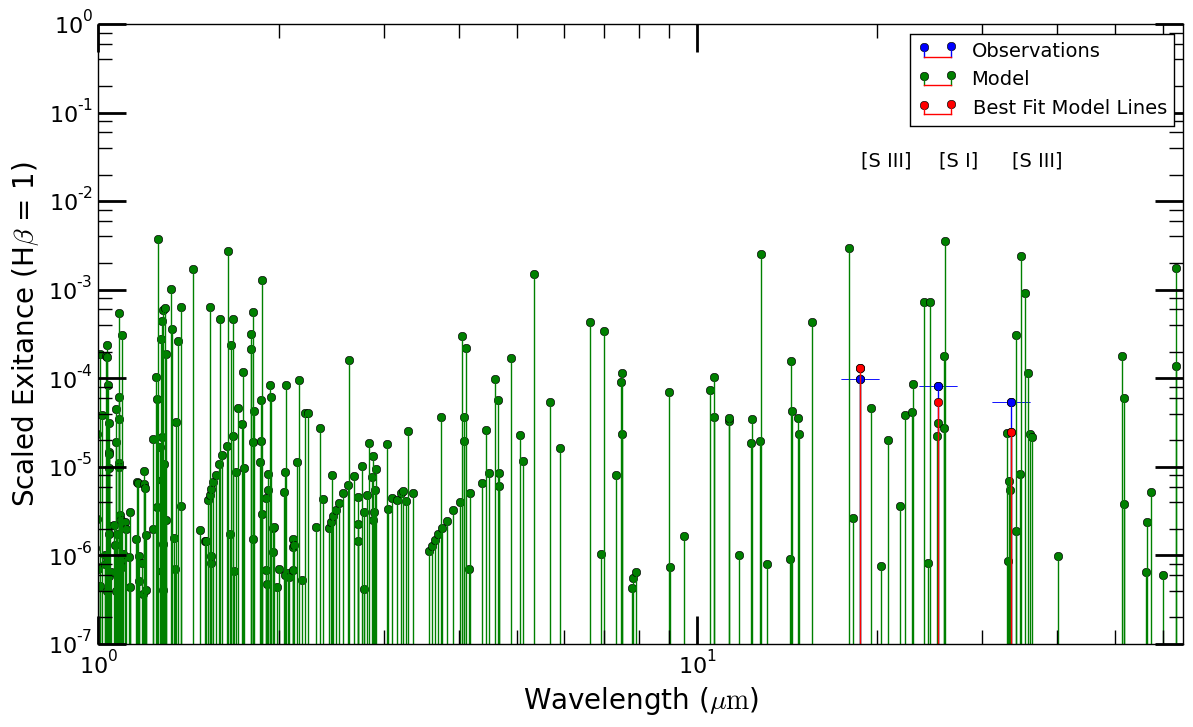

('Lines: ', array(['[S I]', '[S III]', '[S III]'], 
      dtype='|S7'))
('Wavelengths: ', array([25.2490184, 18.712925, 33.4795273], dtype=object))
('Observed:', array([8.174414379294299e-05, 9.763883841934859e-05, 5.449609586196199e-05], dtype=object))
('Simulated:', [5.3614673039999999e-05, 0.0001319131992, 2.46867312e-05])
('Differences: ', array([2.812947075294299e-05, -3.427436078065141e-05,
       2.9809364661961992e-05], dtype=object))


In [141]:
#Trying a specific case
#just set ind, knot_num, and the folder you want to save in
#ind and knot_num are the shock path index and the index of the knot or region that we attempt to fit, respectively
ind = 1
knot_num = 1
folder = 'Matches_GGD7/'

#beginning model matching
newmid, pointnewmid, modnewmid = initialize(shock_paths[ind], lams)

# match_output = match(chisq, knot_num, modnewmid, pointnewmid, obsflux, obsunc) #I guess if you want to modify?
# print(match_output)
# sys.exit()

#the output
match_output = match(chisq, knot_num, modnewmid, pointnewmid, obsflux, obsunc)
print(match_output)

#plotting
#knot num is plus 2 when doing folder+str(...) b/c rawobsflux indexing and the strings are off
plotspectra(newmid[match_output[1][0]],knot_num, match_output[1][2], 
            folder+str(rawobsflux.columns[knot_num+2])
            +'_path'+str(ind), obsflux, obsunc, lams) 

In [123]:
print(newmid)

[                                                      1  \
0         SHOCK 5: Steady Rankine-Hugoniot Shock Code:    
1          ============================================   
2                                         Diffuse Field   
3                 Global Shock-Precursor Iterations:  1   
4                     Calculated by MAPPINGS V v5.1.12    
5      Run  :kappa100_100kms_500.0gcm^3             ...   
6                File :shck_kap1000001.sh5                
7                                     Model Parameters:   
8                                     =================   
9      Abundances     : Solar/Asplund 2009 Abundance...   
10     Pre-ionisation : Default ionisation          ...   
11     Photon Source  : None                        ...   
12                                          Abundances:   
13                                                  El.   
14                                                   H    
15                                                   He

In [67]:
#looping through specific paths and knots, so you can try multiple at once without trying everything
#Changed both loops to be for loops and now testing specific paths from the shock_path list and specific knot_nums


folder = 'Matches_GGD7/'

for i in [0, 1, 2, 3]:
    ind = i

    newmid, pointnewmid, modnewmid = initialize(shock_paths[ind], lams)

    
    for j in [0,1,2,3,4,5,6]:
        knot_num = j

        try:
            #The inputs are knot number, the list of models, and the list of parameters?
            match_output = match(knot_num, modnewmid, pointnewmid, obsflux, obsunc)
            print('Success:', i, shock_paths[i], 'Knot:', j)
            print(match_output)
            #The outputs are the chi square, the best matching spectrum / its index, the model params for the best match, a scaling factor
        
            plotspectra(newmid[match_output[1][0]],knot_num, match_output[1][2], 
                folder+str(rawobsflux.columns[knot_num+2])
                +'_path'+str(ind), obsflux, obsunc, lams)
        
        except Exception as e: print(i, shock_paths[i], 'Knot:', j, e) #outputs the path number, the knot number upon failing
        
        
        j += 1

(0, 'S5_Shocks/NewMid/ShockFiles/ShockSpectrum*.csv', 'Knot:', 0, TypeError('match() takes exactly 6 arguments (5 given)',))
(0, 'S5_Shocks/NewMid/ShockFiles/ShockSpectrum*.csv', 'Knot:', 1, TypeError('match() takes exactly 6 arguments (5 given)',))
(0, 'S5_Shocks/NewMid/ShockFiles/ShockSpectrum*.csv', 'Knot:', 2, TypeError('match() takes exactly 6 arguments (5 given)',))
(0, 'S5_Shocks/NewMid/ShockFiles/ShockSpectrum*.csv', 'Knot:', 3, TypeError('match() takes exactly 6 arguments (5 given)',))
(0, 'S5_Shocks/NewMid/ShockFiles/ShockSpectrum*.csv', 'Knot:', 4, TypeError('match() takes exactly 6 arguments (5 given)',))
(0, 'S5_Shocks/NewMid/ShockFiles/ShockSpectrum*.csv', 'Knot:', 5, TypeError('match() takes exactly 6 arguments (5 given)',))
(0, 'S5_Shocks/NewMid/ShockFiles/ShockSpectrum*.csv', 'Knot:', 6, TypeError('match() takes exactly 6 arguments (5 given)',))
(1, 'fdauphin/7_23_Spec_BGrid/BMF/ShockFiles/ShockSpectrum*.txt', 'Knot:', 0, TypeError('match() takes exactly 6 arguments (5

1
('Success:', 0, 'arubinst_GGD37_mods/kappa_tests/*.csv', 'Knot:', 0)
(915.12040063775, [1, ['100', '500.0'], 3.928411607009148e-09])


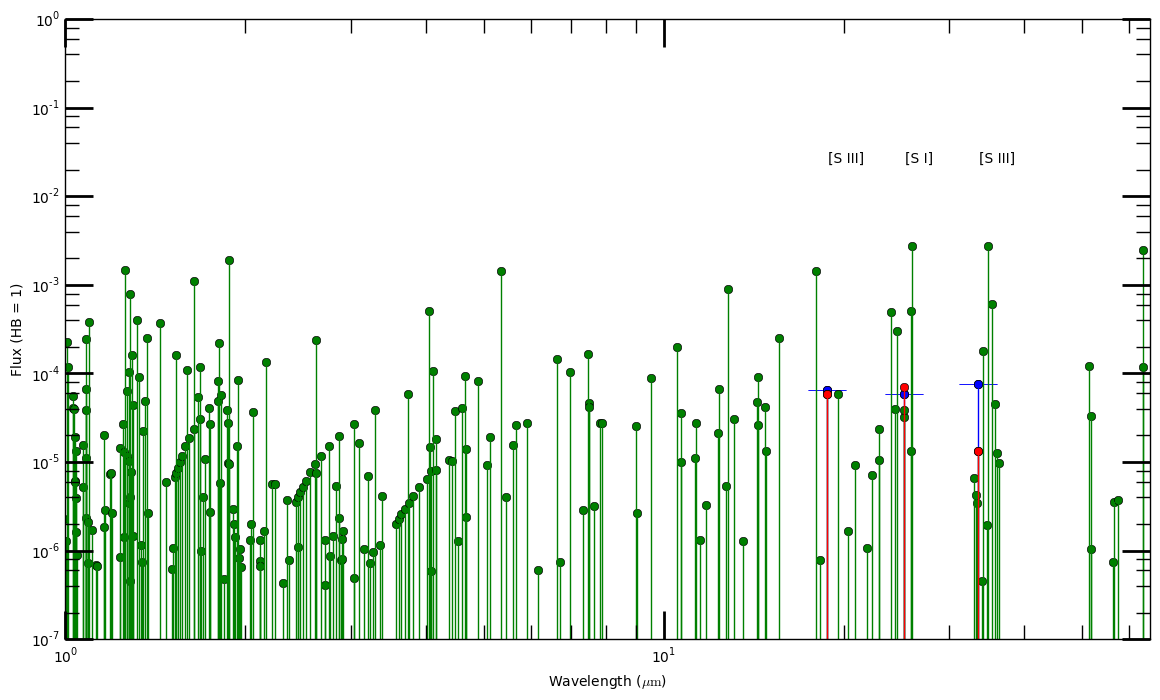

('Lines: ', array(['[S I]', '[S III]', '[S III]'], 
      dtype='|S7'))
('Wavelengths: ', array([25.2490184, 18.712925, 33.4795273], dtype=object))
('Observed:', array([5.927267272245867e-05, 6.477656376097268e-05, 7.705447453919625e-05], dtype=object))
('Simulated:', [7.0450372500000007e-05, 5.8476690000000001e-05, 1.3184034750000001e-05])
('Differences: ', array([-1.1177699777541338e-05, 6.299873760972682e-06,
       6.387043978919625e-05], dtype=object))
1
('Success:', 0, 'arubinst_GGD37_mods/kappa_tests/*.csv', 'Knot:', 1)
(625.936233237313, [1, ['100', '500.0'], 7.766885712591875e-10])


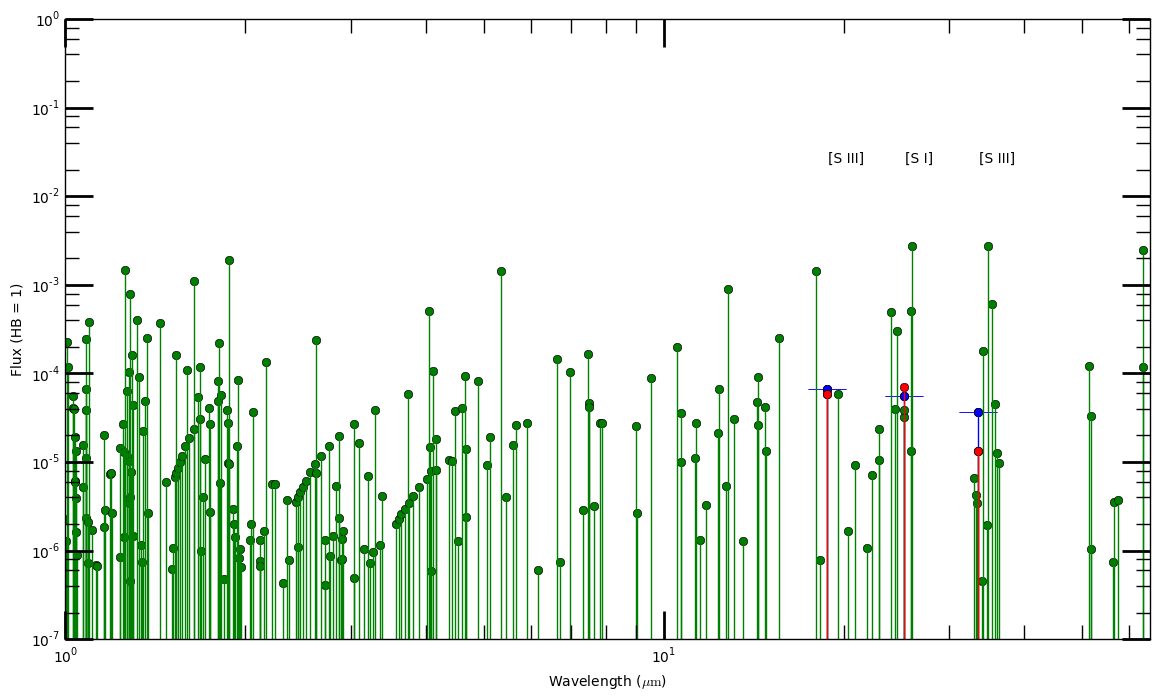

('Lines: ', array(['[S I]', '[S III]', '[S III]'], 
      dtype='|S7'))
('Wavelengths: ', array([25.2490184, 18.712925, 33.4795273], dtype=object))
('Observed:', array([5.567623945942372e-05, 6.650217490986724e-05, 3.711749297294915e-05], dtype=object))
('Simulated:', [7.0450372500000007e-05, 5.8476690000000001e-05, 1.3184034750000001e-05])
('Differences: ', array([-1.4774133040576288e-05, 8.025484909867236e-06,
       2.3933458222949147e-05], dtype=object))
1
('Success:', 0, 'arubinst_GGD37_mods/kappa_tests/*.csv', 'Knot:', 2)
(1866.2064876294353, [1, ['100', '500.0'], 1.7136818714023321e-10])


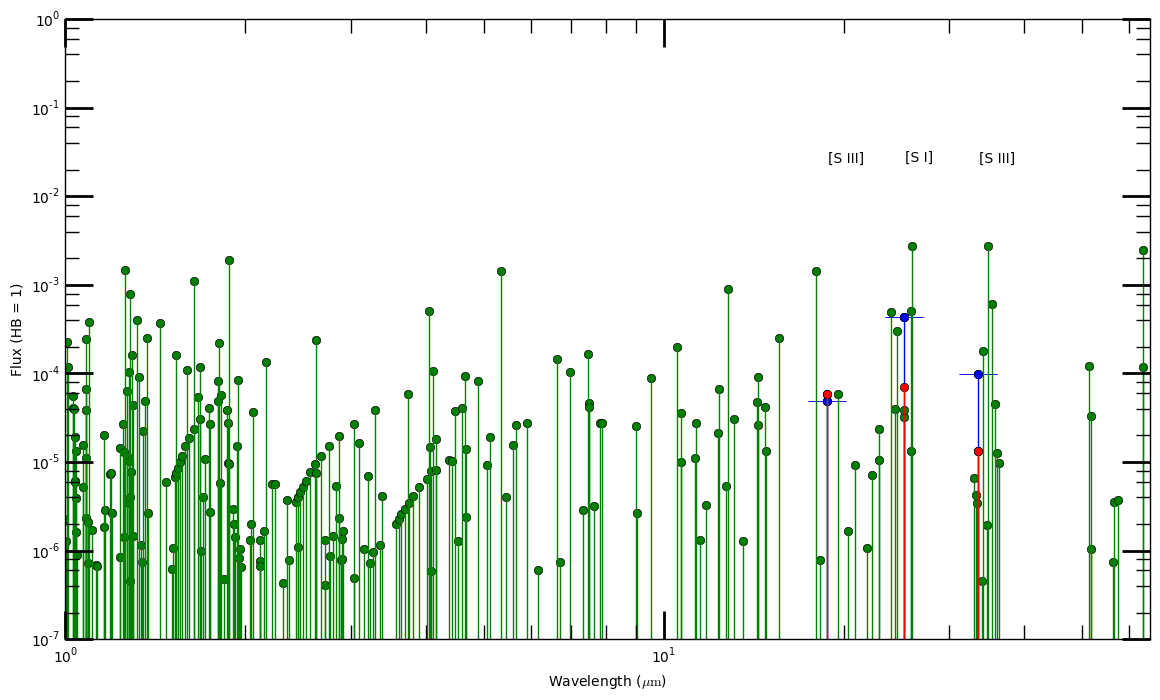

('Lines: ', array(['[S I]', '[S III]', '[S III]'], 
      dtype='|S7'))
('Wavelengths: ', array([25.2490184, 18.712925, 33.4795273], dtype=object))
('Observed:', array([0.00043027255411818373, 4.831130432204168e-05, 9.813233690414717e-05], dtype=object))
('Simulated:', [7.0450372500000007e-05, 5.8476690000000001e-05, 1.3184034750000001e-05])
('Differences: ', array([0.0003598221816181837, -1.0165385677958322e-05,
       8.494830215414718e-05], dtype=object))
0
('Success:', 1, 'arubinst_GGD37_mods/density_tests/*.csv', 'Knot:', 0)
(1124.927460617463, [0, ['100', '1000.0'], 1.9444746152379757e-09])


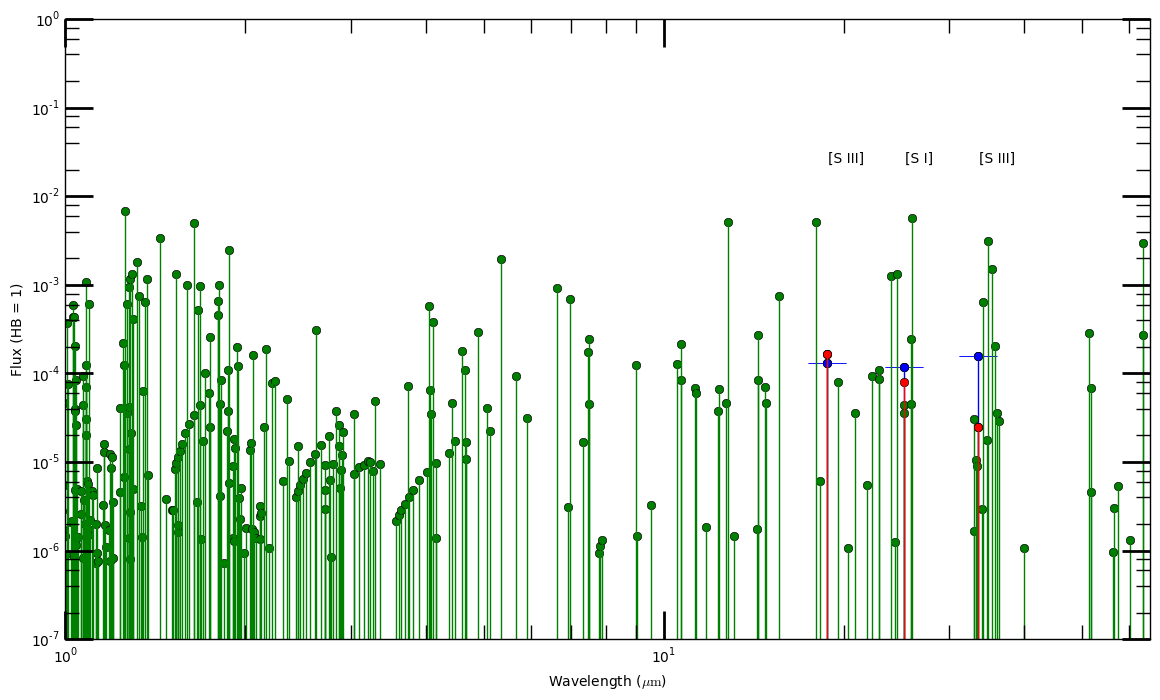

('Lines: ', array(['[S I]', '[S III]', '[S III]'], 
      dtype='|S7'))
('Wavelengths: ', array([25.2490184, 18.712925, 33.4795273], dtype=object))
('Observed:', array([0.00011974826190922733, 0.00013086774337222698,
       0.0001556727404819955], dtype=object))
('Simulated:', [7.948967947000001e-05, 0.00016767258860000001, 2.4701932040000002e-05])
('Differences: ', array([4.025858243922732e-05, -3.6804845227773035e-05,
       0.0001309708084419955], dtype=object))
5
('Success:', 1, 'arubinst_GGD37_mods/density_tests/*.csv', 'Knot:', 1)
(676.0604314133484, [5, ['100', '500.0'], 5.290054659861445e-10])


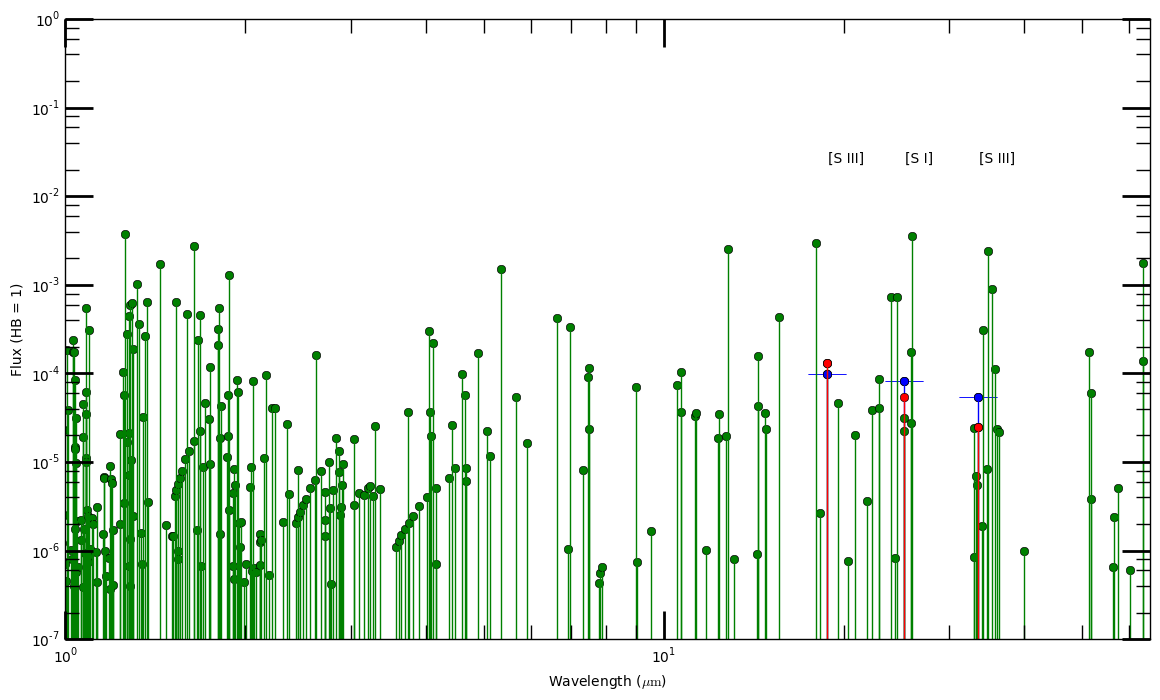

('Lines: ', array(['[S I]', '[S III]', '[S III]'], 
      dtype='|S7'))
('Wavelengths: ', array([25.2490184, 18.712925, 33.4795273], dtype=object))
('Observed:', array([8.174414379294299e-05, 9.763883841934859e-05, 5.449609586196199e-05], dtype=object))
('Simulated:', [5.3614673039999999e-05, 0.0001319131992, 2.46867312e-05])
('Differences: ', array([2.812947075294299e-05, -3.427436078065141e-05,
       2.9809364661961992e-05], dtype=object))
5
('Success:', 1, 'arubinst_GGD37_mods/density_tests/*.csv', 'Knot:', 2)
(2148.7880790530066, [5, ['100', '500.0'], 7.052956573416966e-11])


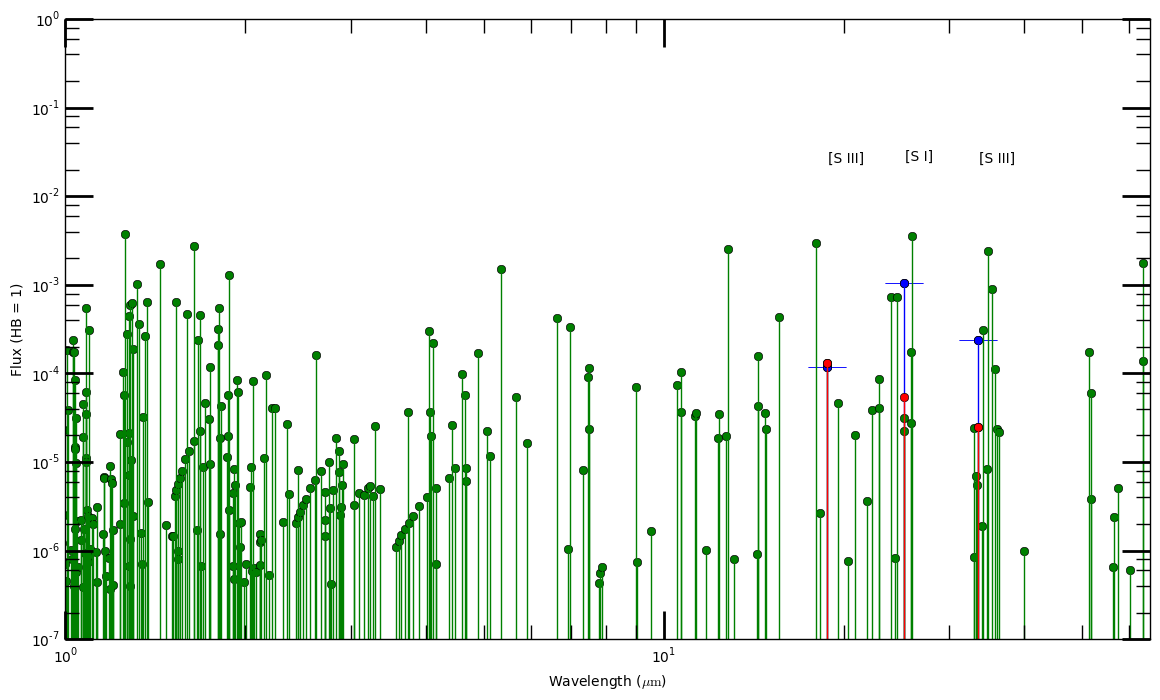

('Lines: ', array(['[S I]', '[S III]', '[S III]'], 
      dtype='|S7'))
('Wavelengths: ', array([25.2490184, 18.712925, 33.4795273], dtype=object))
('Observed:', array([0.0010454484840207716, 0.0001173836894339112, 0.00023843561916263214], dtype=object))
('Simulated:', [5.3614673039999999e-05, 0.0001319131992, 2.46867312e-05])
('Differences: ', array([0.0009918338109807716, -1.4529509766088793e-05,
       0.00021374888796263215], dtype=object))


In [117]:
'''
Note:
allmatch works for all Fe lines, Ne, Si (everything except S)
allmatchred works for all those lines except [FeII] at 1.6 microns
allmatch_g excludes the [NeII] line
allmatch_noFe excludes all three Fe lines and only fits Ne and Si
allmatch_Fe_only tries to fit all three Fe lines (17.9, 26, and 1.6)

One other thing you can try is adjusing the fourth input I put for plotspectrasmall. You should try putting it 
into a specific folder.
'''
#looping through paths to test all different shock spectra models
#The outer loop is set by the len of shock_paths, so it shouldn't need to be changed if you setup your list of paths

#variables used twice, just lengths used for loops
shock_len = len(shock_paths)
knots_len = len(rawobsflux.columns[2:])-3 #minus 1 is because last column is continuum, don't want to model that


folder = 'Matches_GGD7/' #the folder you mean to save your plots / results in

chisq_list = np.zeros((shock_len,knots_len+1)) #This is a list to store chi squared values, which can be used to search through best fits


#looping through shock models
for i in [0, 1]: #range(shock_len):
    
    #gathering relevant spectral lines and model parameters from a chosen model grid, given selected line lambdas
    newmid, pointnewmid, modnewmid = initialize(shock_paths[i], lams)
    
    #looping through knots, j starts at 2 since 0 and 1 are taken up by line name and wavelength
    #Here you shouldn't need to change anything either. The idea is to have j <= the total number of knots you have
    j = 0
    while j <= knots_len:
        knot_num = j  
        
        #attempting a match for a given knot number and path
        try:
            #The inputs are knot number, the list of models, and the list of parameters?
            #The outputs are the chi square, the best matching spectrum / its index, the model params for the best match, a scaling factor
#             match_output = match(chiratio, knot_num, modnewmid, pointnewmid, obsflux, obsunc) #if you're trying ratio of lines
            match_output = match(chisq, knot_num, modnewmid, pointnewmid, obsflux, obsunc)
            print('Success:', i, shock_paths[i], 'Knot:', j)
            print(match_output)
            
            #updating list of chi squares to later check for matches
            chisq_list[i, j] = match_output[0]
            
            #plots when model matches observations
            plotspectra(newmid[match_output[1][0]],knot_num, match_output[1][2], 
                folder+str(rawobsflux.columns[knot_num+2])
                +'_path'+str(i), obsflux, obsunc, lams)
            
            
        except Exception as e: print(i, shock_paths[i], 'Knot:', j, e) #outputs the path #, the knot #, and error upon failing
        
        j += 1

In [76]:
'''
Determining best matches by min chi square if more than one grid works
'''
print(chisq_list)
# print chisq_list[0][5]

#Looping through each knot
for k in [0,1,2,3,4,5,6]:
    test_list = [] #resetting list of chi square vals
    
    #looping through each path
    for l in range(12):
        test_list.append(chisq_list[l][k])  #creating a list of chi squares for a single knot
    
    m = min(i for i in test_list if i > 0)  #grabbing all values greater than 0 and finding the min value
    print("Position:", test_list.index(m))
    print("Chi Square Value:", m)
#     min_value = np.argmin(x) #another way to find the chi squared value if necessary
    
    print('Path:', shock_paths[test_list.index(m)])

[[ 1124.92746062   676.06043141  2148.78807905]
 [ 1081.52022558   703.71721108  1632.68024583]]


IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
'''
The following tests Natalie's observations of HH 7...11
'''

rawobsflux = pd.read_excel("nallen_obs/Dered_Fluxes.xlsx")  # observational data read in
obsflux = rawobsflux[-18:]
rawunc = pd.read_excel("nallen_obs/Dered_Uncertanties.xlsx")
obsunc = rawunc[-18:]

obsflux = obsflux.values  # usable values: flux and uncertainty
obsunc = obsunc.values


obsSi = obsflux[:1]  # separating data by spectral line
obsFe26 = obsflux[1:2]
obsS = obsflux[2:3]
obsFe179 = obsflux[3:4]
obsNe = obsflux[4:5]
obsFe16 = obsflux[13:14]


runcSi = obsunc[:1]  # raw, same for uncertainties
runcFe26 = obsunc[1:2]
runcS = obsunc[2:3]
runcFe179 = obsunc[3:4]
runcNe = obsunc[4:5]
runcFe16 = obsunc[13:14]


uncSi = nonzero(runcSi, obsSi)  # final uncertainties by line
uncFe26 = nonzero(runcFe26, obsFe26)
uncS = nonzero(runcS, obsS)
uncFe179 = nonzero(runcFe179, obsFe179)
uncNe = nonzero(runcNe, obsNe)
uncFe16 = nonzero(runcFe16, obsFe16)

print(rawobsflux)
print(obsflux)

In [ ]:
'''
Attempting to fit the observations
'''
#looping through paths to test all different shock spectra models
#The outer loop is set by the len of shock_paths, so it shouldn't need to be changed if you setup your list of paths

chisq_list = np.zeros((11,7)) #This is a list to store chi squared values, which can be used to search through best fits

for i in [0]:
    ind = i

    newmid, pointnewmid, modnewmid = initialize(shock_paths[ind])
   
    #looping through knots, j starts at 2 since that's the column where the observations start
    #Here you shouldn't need to change anything either. The idea is to have j <= the total number of knots you have
    j = 0
    while j <= 6:
        knot_num = j  
                
        #attempting a match for a given knot number and path
        try:
            #The inputs are knot number, the list of models, and the list of parameters?
            #The outputs are the chi square, the best matching spectrum / its index, the model params for the best match, a scaling factor
            match_output = match(knot_num, modnewmid, pointnewmid)
            print 'Success:', ind, shock_paths[ind], 'Knot:', j
            print match_output
            
            #updating list of chi squares to later check for matches
            chisq_list[i, j-2] = match_output[0]
            
            #plots when model matches observations
            plotspectra(newmid[match_output[1][0]],knot_num, match_output[1][2], 'Match_Figures/'+rawobsflux.columns[knot_num]+'_path'+str(ind))
            
        except: 
            print 'Fail:', ind, shock_paths[ind], 'Knot:', j #outputs the path number, the knot number upon failing
            
        j += 1
        print j